In [1]:
import os
import scanpy as sc
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from scipy.spatial import distance_matrix

In [240]:
def read_samples_into_dict(file_paths):
    """
    Reads multiple AnnData objects (samples) from a list of file paths and stores them in a dictionary.

    Parameters:
    ----------
    file_paths : list of str
        A list of file paths to the `.h5ad` files to be read.

    Returns:
    -------
    adata_dict : dict
        A dictionary where the keys are the filenames (without extensions) 
        and the values are the corresponding AnnData objects.
    """
    adata_dict = {}
    
    for file in file_paths:
        adata = sc.read_h5ad(file)
        file_name = os.path.splitext(os.path.basename(file))[0]
        adata_dict[file_name] = adata
        
    return adata_dict

In [241]:
def save_sample(adata, graph, output_dir, sample_name):
    """
    Save the AnnData object and PyTorch Geometric graph for a sample.

    Parameters:
    - adata: AnnData object
    - graph: PyTorch Geometric Data object
    - output_dir: Directory to save the files
    - sample_name: Name of the sample (used for filenames)
    """
    # ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # save the AnnData object
    adata_file = os.path.join(output_dir, f"{sample_name}.h5ad")
    adata.write(adata_file)
    print(f"Saved AnnData object to {adata_file}")
    
    # Save the PyTorch Geometric graph
    graph_file = os.path.join(output_dir, f"{sample_name}_graph.pt")
    torch.save(graph, graph_file)
    print(f"Saved graph to {graph_file}")

In [242]:
def print_sample(sample_name, adata):
    """
    Visualizes spatial embeddings of a single AnnData object and prints its details.

    Parameters:
    ----------
    sample_name : str
        The name of the sample.
    adata : AnnData
        The AnnData object containing spatial and gene expression data.

    Behavior:
    --------
    - Prints the sample name and the corresponding AnnData object.
    - Determines the color key (`domain`, `region`, or `layer`) based on the sample name prefix.
    - Plots the spatial embedding of the AnnData object using `scanpy.pl.embedding`.

    Notes:
    -----
    - The `domain` is used for samples starting with "MERFISH".
    - The `region` is used for samples starting with "STARmap".
    - The `layer` is used for samples starting with "BaristaSeq".
    - The spatial embedding is visualized using the `spatial` basis.
    """
    if sample_name.startswith("MERFISH"):
        domain = "domain"
    elif sample_name.startswith("STARmap"):
        domain = "region"
    elif sample_name.startswith("BaristaSeq"):
        domain = "layer"
    
    print(f"Sample: {sample_name}")
    print(adata)
    sc.pl.embedding(adata, basis="spatial", color=domain)

In [243]:
def preprocess_sample(adata, min_cells=3, min_genes=3):
    """
    Preprocesses a single AnnData object by applying filtering, normalization, and dimensionality reduction steps.

    Parameters:
    ----------
    adata : AnnData
        The AnnData object containing spatial and gene expression data.
    min_cells : int, optional
        The minimum number of cells in which a gene must be expressed to retain the gene. Default is 3.
    min_genes : int, optional
        The minimum number of genes that must be expressed in a cell to retain the cell. Default is 5.

    Behavior:
    --------
    - Dynamically adjusts the `min_genes` threshold to be the greater of the provided `min_genes` value or 1% of the total number of genes in the dataset.
    - Filters genes expressed in fewer than `min_cells` cells.
    - Filters cells with fewer than the dynamically determined `min_genes` threshold.
    - Normalizes gene expression values to a target sum of 1e5 per cell.
    - Log-transforms the normalized gene expression values.
    - Scales the gene expression values to unit variance and zero mean.
    - Performs PCA to reduce dimensionality to 50 components.

    Notes:
    -----
    - The dynamic adjustment of `min_genes` ensures that the threshold scales appropriately with the size of the dataset.
    - This preprocessing pipeline is designed for spatial omics data but can be applied to other single-cell datasets.

    Returns:
    -------
    None
        The function modifies the input AnnData object in place.
    """
    total_genes = adata.n_vars
    min_genes_dynamic = max(min_genes, int(total_genes * 0.01))
    

    sc.pp.filter_genes(adata, min_cells=min_cells)              # filter genes expressed in less than min_cells cells
    sc.pp.filter_cells(adata, min_genes=min_genes_dynamic)      # filter cells with less than min_genes genes expressed
    sc.pp.normalize_total(adata, target_sum=1e5)                # normalize gene expression values with a target sum per cell of 1e5
    sc.pp.log1p(adata)                                          # log transform gene expression values (log1p(x) = log(x+1))
    sc.pp.scale(adata)                                          # scale gene expression values to unit variance and zero mean
    sc.pp.pca(adata, n_comps=50)                                # perform PCA with 50 components

In [244]:
def euclid_dist(t1, t2):
    """
    Computes the Euclidean distance between two vectors.

    Parameters:
    ----------
    t1 : array-like
        The first vector.
    t2 : array-like
        The second vector.

    Returns:
    -------
    float
        The Euclidean distance between the two vectors.

    Notes:
    -----
    - The Euclidean distance is calculated as the square root of the sum of squared differences 
      between corresponding elements of the two vectors.
    - Both input vectors must have the same shape.
    """
    sum = 0
    for i in range(t1.shape[0]):
        sum += (t1[i] - t2[i])**2
    return np.sqrt(sum)

In [245]:
def create_graph(adata, method="knn", n_neighbors=10):
    """
    Creates a graph representation of spatial data from an AnnData object.

    Parameters:
    ----------
    adata : AnnData
        The AnnData object containing spatial and gene expression data.
    method : str, optional
        The method to use for graph construction. Options are "knn" or "pairwise". Default is "knn".
        - "knn": Constructs a k-nearest neighbors graph based on spatial distances.
        - "pairwise": Constructs a fully connected graph with edge weights computed using a Gaussian kernel.
    n_neighbors : int, optional
        The number of nearest neighbors to consider for the "knn" method. Default is 10.

    Returns:
    -------
    Data : torch_geometric.data.Data
        A PyTorch Geometric Data object containing the graph representation of the spatial data.
        - For "knn": Includes `x` (node features) and `edge_index` (graph connectivity).
        - For "pairwise": Includes `x` (node features), `edge_index` (graph connectivity), and `edge_attr` (edge weights).

    Notes:
    -----
    - For "knn":
        - Constructs a k-nearest neighbors graph based on spatial distances.
        - The adjacency matrix is symmetrized to ensure bidirectional edges.
        - The `edge_index` is derived from the adjacency matrix in COO (coordinate) format.
    - For "pairwise":
        - Constructs a fully connected graph where edge weights are computed using a Gaussian kernel:
          `weight = exp(-distance^2 / (2 * l^2))`.
        - The `edge_attr` attribute contains the computed edge weights.
    - The `x` attribute in the returned graph corresponds to the PCA-transformed features stored in `adata.obsm["X_pca"]`.
    - The adjacency matrix is stored in `adata.obsm['adj']` for both methods.
    """
    if method == "knn":
        position = adata.obsm['spatial']
    
        # calculate distance matrix
        dist_mat = distance_matrix(position, position)
        n_spot = dist_mat.shape[0]
                
        # find k-nearest neighbors
        interaction = np.zeros([n_spot, n_spot])  
        for i in range(n_spot):
            vec = dist_mat[i, :]
            distance = vec.argsort()
            for t in range(1, n_neighbors + 1):
                y = distance[t]
                interaction[i, y] = 1
                    
        #transform adj to symmetrical adj
        adj = interaction
        adj = adj + adj.T
        adj = np.where(adj>1, 1, adj)
        
        adata.obsm['adj'] = adj

        # convert adjacency matrix to COO format for edge index
        edge_index = np.array(np.nonzero(adj))
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        return Data(x=torch.tensor(adata.obsm["X_pca"].copy(), dtype=torch.float), edge_index=edge_index)

    elif method == "pairwise":
        X = adata.obsm["spatial"]
        n = X.shape[0]

        # calculate adjacency matrix based on euclidean distance between all pairs of cells
        adj = np.empty((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                adj[i][j] = euclid_dist(X[i], X[j])

        # calculate the edge weights based on the euclidean distances
        l = np.mean(adj)
        adj_exp = np.exp(-1 * (adj**2) / (2 * (l**2)))

        adata.obsm['adj'] = adj_exp

        # convert adjacency matrix to COO format for edge index and edge attributes
        edge_index = np.array(np.nonzero(adj))
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        edge_attr = torch.tensor(adj_exp[edge_index[0], edge_index[1]], dtype=torch.float)

        return Data(x=torch.tensor(adata.obsm["X_pca"].copy(), dtype=torch.float), edge_index=edge_index, edge_attr=edge_attr)
        
    else:
        raise ValueError("Invalid method. Choose between 'knn' and 'pairwise'")

In [246]:
class SpatialOmicsDataset(Dataset):
    """
    A custom PyTorch Geometric dataset for spatial omics data.
    """
    def __init__(self, samples):
        super().__init__()
        self.samples = list(samples.values())

    def len(self):
        return len(self.samples)

    def get(self, idx):
        return self.samples[idx]

In [247]:
file_paths = [
    "../data/domain/raw/MERFISH_small1.h5ad",
    "../data/domain/raw/MERFISH_small2.h5ad",
    "../data/domain/raw/MERFISH_small3.h5ad",
    "../data/domain/raw/MERFISH_small4.h5ad",
    "../data/domain/raw/MERFISH_small5.h5ad",
    "../data/domain/raw/STARmap1.h5ad",
    "../data/domain/raw/STARmap2.h5ad",
    "../data/domain/raw/STARmap3.h5ad",
    "../data/domain/raw/STARmap4.h5ad",
    "../data/domain/raw/BaristaSeq1.h5ad",
    "../data/domain/raw/BaristaSeq2.h5ad",
    "../data/domain/raw/BaristaSeq3.h5ad"
]

samples = read_samples_into_dict(file_paths)
len(samples)

12

In [248]:
output_dir = "../data/domain/processed"
graphs = []

for sample_name, adata in samples.items():
    if "X_pca" in adata.obsm:
        print(f"Sample {sample_name} is already preprocessed. Skipping preprocessing.")
    else:
        preprocess_sample(adata)
    graph = create_graph(adata, method="knn")
    graphs.append(graph)
    save_sample(adata, graph, output_dir, sample_name)

dataset = SpatialOmicsDataset({name: graph for name, graph in zip(samples.keys(), graphs)})
torch.save(dataset, "../data/domain/dataset.pt")
print("Saved dataset to ../data/domain/dataset.pt")

Saved AnnData object to ../data/domain/processed/MERFISH_small1.h5ad
Saved graph to ../data/domain/processed/MERFISH_small1_graph.pt
Saved AnnData object to ../data/domain/processed/MERFISH_small2.h5ad
Saved graph to ../data/domain/processed/MERFISH_small2_graph.pt
Saved AnnData object to ../data/domain/processed/MERFISH_small3.h5ad
Saved graph to ../data/domain/processed/MERFISH_small3_graph.pt
Saved AnnData object to ../data/domain/processed/MERFISH_small4.h5ad
Saved graph to ../data/domain/processed/MERFISH_small4_graph.pt
Saved AnnData object to ../data/domain/processed/MERFISH_small5.h5ad
Saved graph to ../data/domain/processed/MERFISH_small5_graph.pt
Saved AnnData object to ../data/domain/processed/STARmap1.h5ad
Saved graph to ../data/domain/processed/STARmap1_graph.pt
Saved AnnData object to ../data/domain/processed/STARmap2.h5ad
Saved graph to ../data/domain/processed/STARmap2_graph.pt
Saved AnnData object to ../data/domain/processed/STARmap3.h5ad
Saved graph to ../data/domain/

In [249]:
x = samples["MERFISH_small1"].obsm["adj"]
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Sample: MERFISH_small1
AnnData object with n_obs × n_vars = 5488 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


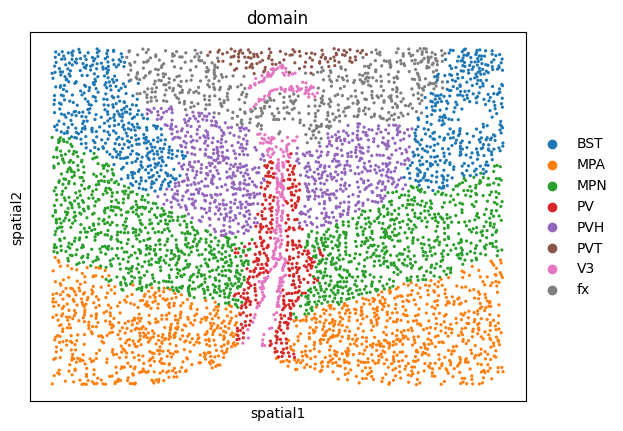

Sample: MERFISH_small2
AnnData object with n_obs × n_vars = 5557 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


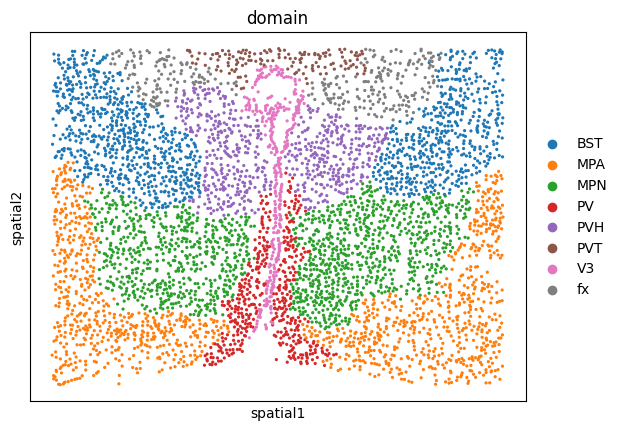

Sample: MERFISH_small3
AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


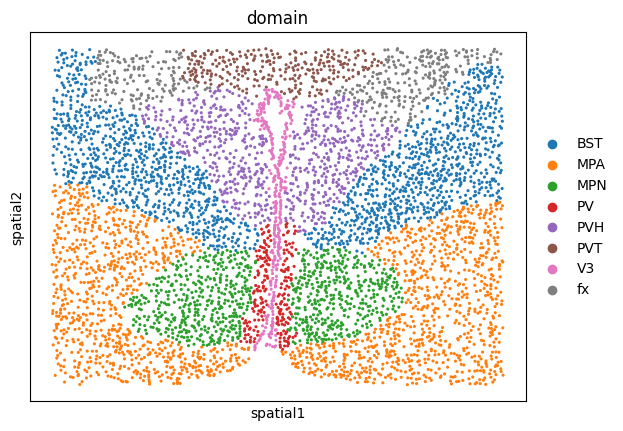

Sample: MERFISH_small4
AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


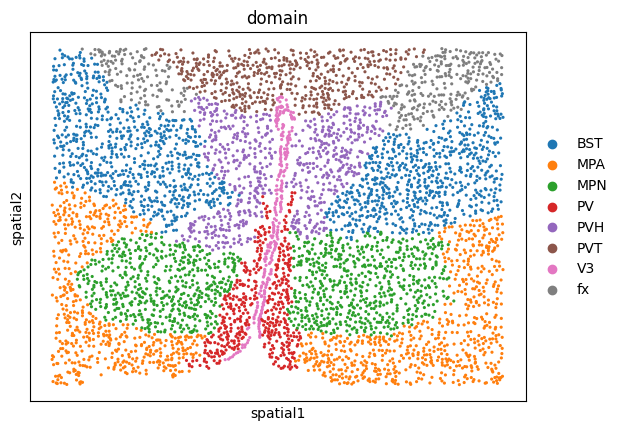

Sample: MERFISH_small5
AnnData object with n_obs × n_vars = 5543 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


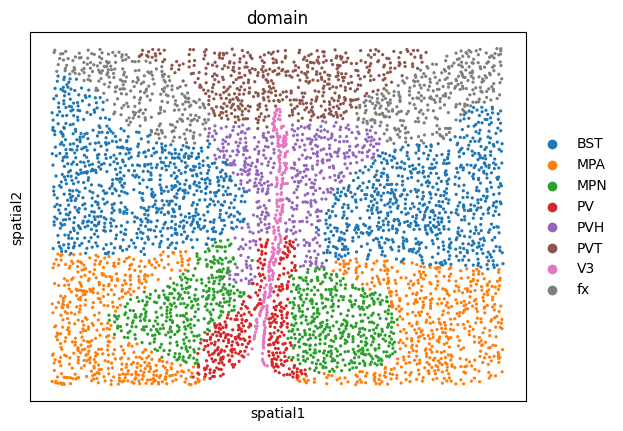

Sample: STARmap1
AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'label_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


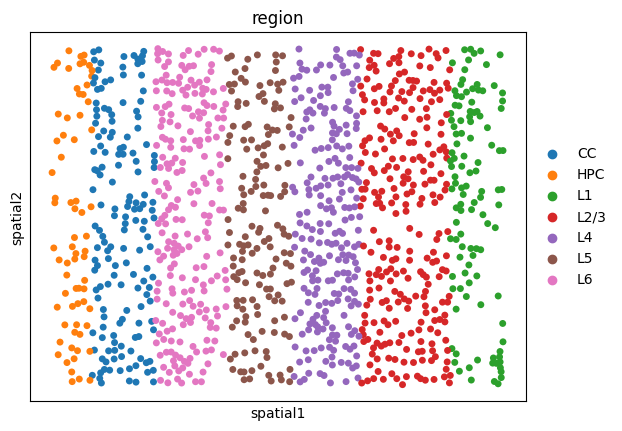

Sample: STARmap2
AnnData object with n_obs × n_vars = 1049 × 166
    obs: 'ct', 'region', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'ct_colors', 'region_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


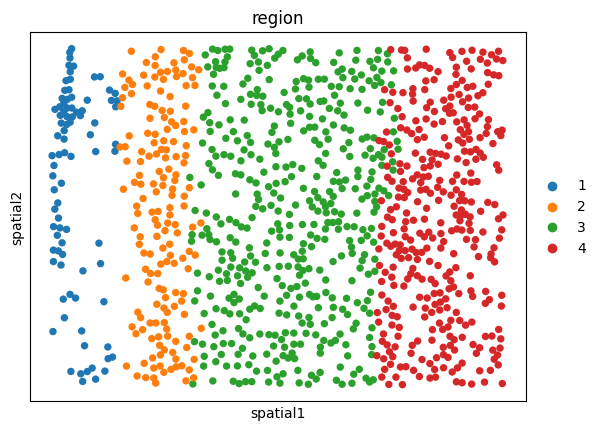

Sample: STARmap3
AnnData object with n_obs × n_vars = 1053 × 166
    obs: 'ct', 'region', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'ct_colors', 'region_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


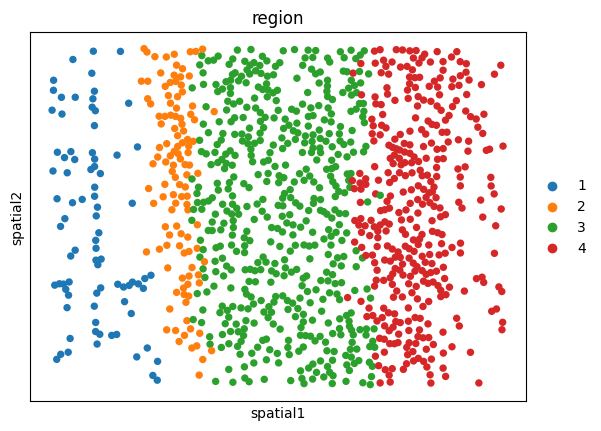

Sample: STARmap4
AnnData object with n_obs × n_vars = 1088 × 166
    obs: 'ct', 'region', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'ct_colors', 'region_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


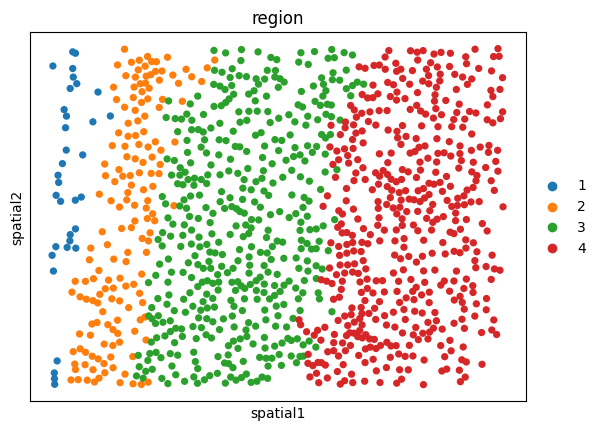

Sample: BaristaSeq1
AnnData object with n_obs × n_vars = 1512 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'layer_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


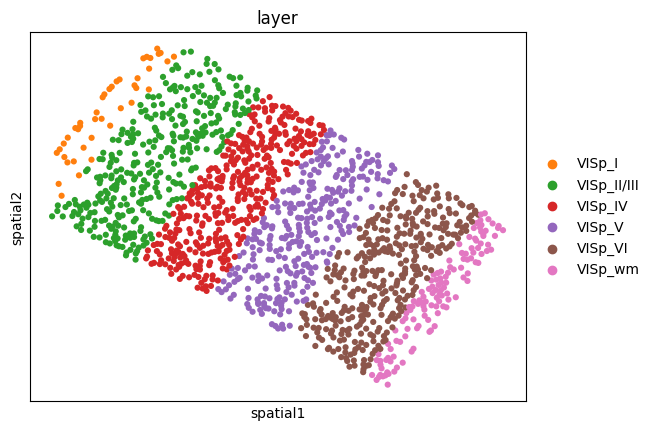

Sample: BaristaSeq2
AnnData object with n_obs × n_vars = 2017 × 78
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'layer_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


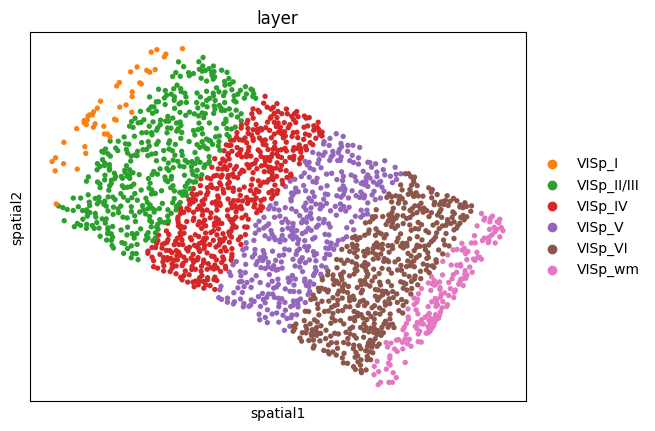

Sample: BaristaSeq3
AnnData object with n_obs × n_vars = 1627 × 77
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'layer_colors', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'adj'
    varm: 'PCs'


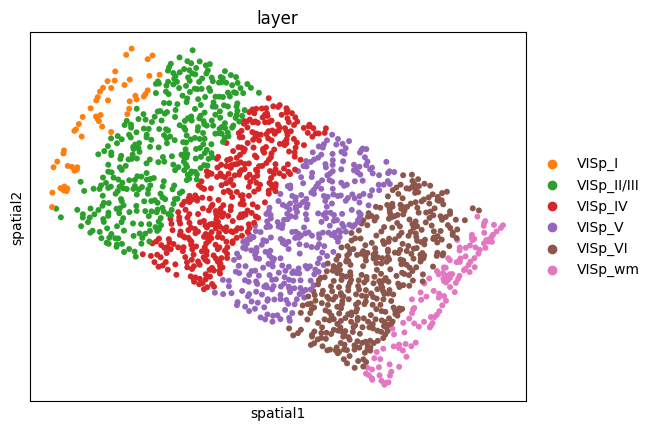

In [250]:
for sample_name, adata in samples.items():
    print_sample(sample_name, adata)